# Заглянем глубже: ядерная оценка плотности распределения
Оцениватель плотности - алгоритм, выдающий для N-мерного набора данных оценку N-мерного распределения вероятности, из которого взята эта выборка данных. Для этого алгоритм GMM представляет плотность распределения в виде взвешенной суммы Гауссовых распределений. Ядерная оценка плотности распределения (KDE) - в некотором смысле алгоритм, доводящий идею смеси Гауссовых функций до логического предела: в нем используется смесь, состоящая из одной Гауссовой компоненты *для каждой точки*, что приводит к непараметрическому оценивателю плотности.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Обоснование метода KDE: гистограммы
Для примера сгенерируем данные на основе двух нормальных распределений:

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

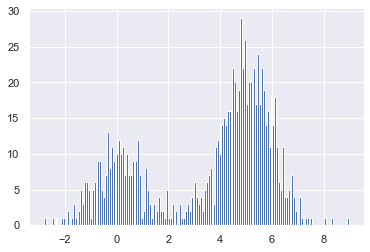

In [3]:
hist = plt.hist(x, bins=160)

Одна из проблем использования гистограмм заключается в том, что конкретный выбор размера и расположения интервалов может приветси к представлениям с качественно различными признаками. Например, если посмотреть на версию этих данных из 20 точек, конкретный выбор интервалов может привести к совершенно иной интерпретацией данных.

In [4]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

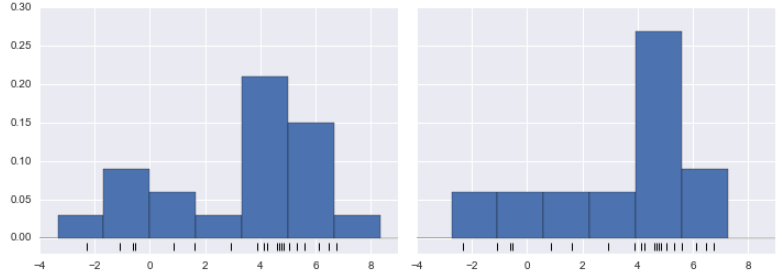

Из гистограммы слева очевидно, что мы имеем дело с бимодальным распределением. Справа же мы видим унимодальное распределение с длинным "хвостом". Хотя, они обе построены на одних данных.

Гистограммы можно рассматривать как "стопки" блоков, в котором для каждой точки набора данных в соответствующий интервал помещается один блок.

(-0.2, 8.0)

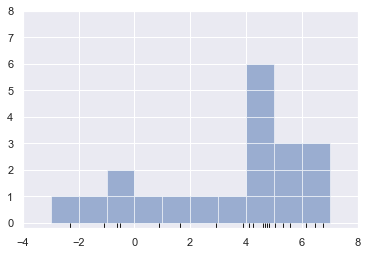

In [5]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

Здесь проблема в том, что высота "стопки" блоков часто отражает не фактическую плотность близлежащих точек, а случайные стечения обстоятельств, выражающиеся в выравнивании интервалов по точкам данных. Что если вместо складывания блоков в "стопки", мы складывали бы блоки, выровненные *по интервалам*:

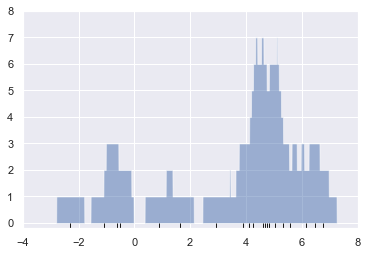

In [6]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

Результат выглядит неряшливо, но отражает подлинные характеристики данных гораздо надежнее, чем стандартная гистограмма.

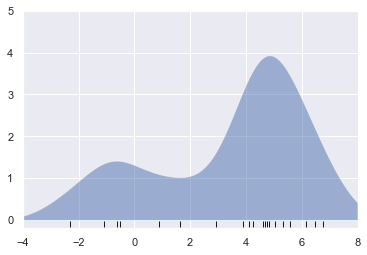

In [7]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

Этот сглаженный график со вкладом Гауссового распределения в соответствующих всем исходным точкам местам обеспечивает намного более точное представление о форме распределения данных, причем с намного меньшей дисперсией, то есть отличия выборок приводят к намного меньшим его изменениям.
## Ядерная оценка плотности распределения на практике
Свободными параметрами ядерной оценки плотности распределения являются *ядро* (kernel), определяющее форму распределения в каждой точке, и *ширина ядра* (kernel bandwidth), определяющая размер ядра в каждой точке. На практике для ядерной оценки плотности распределения существует множество различных ядер (реализация KDE в Scikit-Learn поддерживает исп. 1 из 6 ядер).

В силу того, что метод KDE может потребовать значительных вычислительных затрат, этот оцениватель использует "под капотом" алгоритм на основе деревьев и умеет достигать компромисса между временем вычислений и точностью с помощью параметров **atol** (absolute tolerance, допустимая абсолютная погрешность. Определить ширину ядра - свободный параметр - можно стандартными инструментами перекрестной проверки.

(-0.02, 0.22)

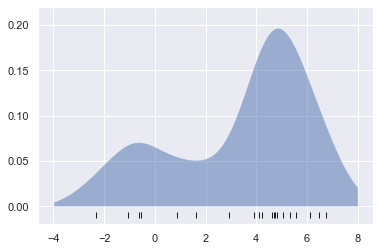

In [8]:
from sklearn.neighbors import KernelDensity

# Создание экземпляра модели KDE и ее обучение
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples возвращает логарифм плотности
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

Результат нормализовался так, что теперь площадь под кривой равна 1.

**Выбор ширины ядра путем перекрестной проверки.** Выбор ширины ядра в методе KDE исключительно важен для получения удовлетворительной оценки плотности. Это и есть тот параметр, который при оценке плотности служит для выбора компромисса между систематической ошибкой и дисперсией. Слишком маленькая ширина ядра приводит к оценке с высокой дисперсией, то есть переобучению, при которой наличие или отсутствие оной-единственной точки может серьезно повлиять на модель. Слишком же широкое ядро ведет к оценке со значительной систематической ошибкой, то есть недообучению, при которой структура данных размывается этим широким ядром.

В контексте машинного обучения мы уже видели, что выбор подобных гиперпараметров зачастую производится эмпирически посредством перекрестной проверки. Учитывая это, оцениватель **KernelDensity** из библиотеки Scikit-Learn спроектирован в расчете на непосредственное использование его в стандартах инструмента Scikit-Learn для поиска по сетке.

In [9]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

In [10]:
# Оптимальная ширина ядра
grid.best_params_

{'bandwidth': 1.1233240329780276}

## Пример: не столь наивный байес
В случае наивного байесовского классификатора порождающая модель - это просто выровненная по осям координат Гауссова функция. Алгоритм оценки плотности, например KDE, позволяет убрать "наивную" составляющую и произвести ту же самую классификацию с более сложными порождающими моделями для каждого из классов.

Общая методика порождающей классификации такова.

1. Разбиение обучающих данных по меткам.
2. Для каждого набора, находится порождающая модель путем обучения KDE. Это дает возможность вычисления функции правдоподобия   P(*x*|*y*) для каждого наблюдения *x* и метки *y*.
3. Вычисляем априорную верятность принадлежности к классу (class prior), P(*y*), на основе количества экземпляров каждого класса в обучающей последовательности.
4. Для неизвестной точки *х* апостериорная вероятность принадлежности к классу равна P(*y*|*x*) *a* P(*x*|*y*) P(*y*). Метка каждой точки - класс, при котором достигается максимум этой апостериорной вероятности.

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Байесовская порождающая классификация на основе метода KDE
    
    Параметры
    ----------
    bandwidth : float
        Ширина ядра в каждом классе
    kernel : str
        Название ядра, передаваемое функции KernelDensity
    """
    
    # Метод инициализации класса:
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
    
    # Обрабатываем обучающие данные:
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
       
    # Логика для предсказания меток новых данных:
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### Внутреннее устройство пользовательского оценивателя
• Каждый оцениватель в библиотеке Scikit-Learn представляет собой класс, наследующий класс BaseEstimator, а также   соответствующую примесь (mixin), которые обеспечивают стандартную функциональность.

• В библиотеке Scikit-Learn важно, чтобы в методе инициализации *не содержалось никаких команд, кроме* присваивания объекту self переданных значений по имени. Аналогично все аргументы метода __ init __ должны быть объявлены явным образом, то есть следует избегать аргументов * args или **kwargs, так как они не могут быть корректно обработаны внутри процедур перекрестной проверки. 

• Далее идет метод fit(), в котором мы обрабатываем обучающие данные. В нем мы находим в обучающих данных уникальные классы, обучаем модель KernelDensity для всех классов и вычисляем априорные вероятности на основе количеств исходных выборок. Метод fit() всегда должен возвращать объект self, чтобы можно было связывать команды в цепочку.

• Все сохраняемые результаты обучения сохраняются с подчеркиванием в конце чтобы можно было быстро посмотреть список членов оценивателя (TAB).

• Т.к. мы имеем дело с вероятностным классификатором, мы реализовали метод predict_proba(), возвращающий массив формы [n_samples, n_classes] вероятностей классов. Элемент [i, j] этого массива представляет собой апостериорную вероятность того, что выборка i - член класса j, вычисленная путем умножения функции правдоподобия на априорную вероятность и нормализации.

• Эти вероятности используются в методе predict(), который возвращает класс с максимальной вероятностью.
### Использование пользовательского оценивателя

In [42]:
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

res = (
    pd.DataFrame({
        "mean_test_score": grid.cv_results_["mean_test_score"],
        "mean_fit_time": grid.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid.cv_results_["params"]).add_prefix("param_"))
)


scores = res['mean_test_score']

C:\Users\Георгий\AppData\Local\Temp\ipykernel_14272\2282408928.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  .join(pd.io.json.json_normalize(grid.cv_results_["params"]).add_prefix("param_"))


{'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


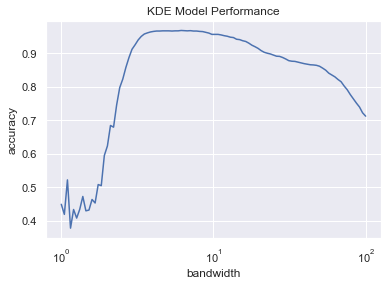

In [44]:
plt.semilogx(bandwidths, res['mean_test_score'])
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

Как видим, этот "не столь наивный" байесовский классификатор достигает точности перекрестной проверки в более чем 96%, по сравнению с "наивным" - 80%.

Одно из преимуществ подобного порождающего классификатора - удобство интерпретации результатов: мы получаем для каждой известной выборки не только вероятностную классификацию, но и *полную модель* распределения точек, с которыми мы ее сравниваем. При необходимости это позволяет пролить свет на на причины того, почему конкретная классификация именно такова, причины, которые такие алгоритмы, как SVM и случайные леса, скрывают.

Чтобы достичь большего можно внести в нашу модель классификатора KDE некоторые усовершенствования:

1. Допустить независимое изменение ширины ядра для каждого класса;
2. Оптимизировать ширину ядер не на основе оценки точности предсказания, а на основе функции правдоподобия для обучающих данных при порождающей модели для каждого класса, то есть использовать оценки эффективности непосредственно из функции KernelDensity, а не общую оценку точности предсказания.